In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
import pandas as pd
import os
import shutil
import sys
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import random

import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow import keras
import tensorflow

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [3]:
path_data = '../Data_augmented_4_classes_train_test_val'

In [4]:
Train_NORMAL = os.listdir(path_data+'/Train/NORMAL/')
print('Train_NORMAL = ', len(Train_NORMAL))

Train_Pneumocystis = os.listdir(path_data+'/Train/Pneumocystis/')
print('Train_Pneumocystis = ', len(Train_Pneumocystis))

Train_Streptococcus = os.listdir(path_data+'/Train/Streptococcus/')
print('Train_Streptococcus = ', len(Train_Streptococcus))

Train_Covid = os.listdir(path_data+'/Train/COVID/')
print('Train_Covid = ', len(Train_Covid))

Train_NORMAL =  497
Train_Pneumocystis =  488
Train_Streptococcus =  475
Train_Covid =  465


In [5]:
Val_NORMAL = os.listdir(path_data+'/val/NORMAL/')
print('Val_NORMAL = ', len(Val_NORMAL))

Val_Pneumocystis = os.listdir(path_data+'/val/Pneumocystis/')
print('Val_Pneumocystis = ', len(Val_Pneumocystis))

Val_Streptococcus = os.listdir(path_data+'/val/Streptococcus/')
print('Val_Streptococcus = ', len(Val_Streptococcus))

Val_Covid = os.listdir(path_data+'/val/COVID/')
print('Val_Covid = ', len(Val_Covid))

Val_NORMAL =  138
Val_Pneumocystis =  129
Val_Streptococcus =  128
Val_Covid =  131


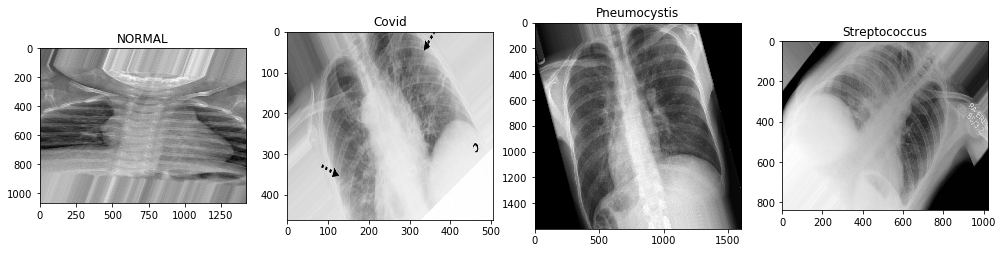

In [6]:
# ref https://www.kaggle.com/feyzazkefe/pneumonia-detection-using-cnn-89-42-acc

img_name = Train_NORMAL[0]
img_normal = load_img(path_data+'/Train/NORMAL/' + img_name)

img_name_1 = Train_Covid[0]
img_Covid = load_img(path_data+'/Train/COVID/' + img_name_1)

img_name_2 = Train_Pneumocystis[0]
img_Pneumocystis = load_img(path_data+'/Train/Pneumocystis/' + img_name_2)

img_name_3 = Train_Streptococcus[1]
img_Streptococcus = load_img(path_data+'/Train/Streptococcus/' + img_name_3)



fig, axs = plt.subplots(1,4,figsize=(17,10))
axs[0].imshow(img_normal)
axs[0].set_title("NORMAL")

axs[1].imshow(img_Covid)
axs[1].set_title("Covid");


axs[2].imshow(img_Pneumocystis)
axs[2].set_title("Pneumocystis")

axs[3].imshow(img_Streptococcus)
axs[3].set_title("Streptococcus");


# plt.savefig("../Assets/plot_01_assets_1_4classes_second_app.png")

In [7]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# load the model

In [8]:
path_1 = '../Codes/Models_Colab/model_epoch_14_loss_0.46_acc_0.54_val_acc_0.64_.h5'
model = keras.models.load_model(path_1)
# path_data = '../Data_augmented_4_classes_train_test_val'

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 108, 108, 64)     

Check out the model on augmented data/Test folder

In [10]:
path_data = '../Data_augmented_4_classes_train_test_val'

In [11]:
DoubleCheck_datagen = image.ImageDataGenerator(rescale=1./255)
DoubleCheck_generator = DoubleCheck_datagen.flow_from_directory(
                    directory=path_data+'/Test/',
                    # directory='../Dataset_4_classe_second_approach/Train/',
#                     directory='../Codes/Models/Test_Data_Set_Sec_app/',
                    target_size=(224,224),
                    color_mode="rgb",
                    classes=None,
                    class_mode="categorical",
                    batch_size=32,
                    shuffle=True,
                    seed=1234,
                    save_to_dir=None,
                    save_prefix="",
                    save_format="png",
                    follow_links=False,
                    subset=None,
                    interpolation="nearest")


model.evaluate(DoubleCheck_generator)

Found 529 images belonging to 4 classes.
17/17 [==============================] - 7s 385ms/step - loss: 0.4362 - accuracy: 0.5369


[0.43622177839279175, 0.5368620157241821]

In [12]:
for idx in range(len(model.layers)):
    print(model.get_layer(index = idx).name)

conv2d_8
batch_normalization_8
conv2d_9
batch_normalization_9
max_pooling2d_6
dropout_8
conv2d_10
batch_normalization_10
max_pooling2d_7
dropout_9
flatten_2
dense_4
dropout_10
dense_5


# Check out images using GRAD-CAM

In [13]:
# ref: modified codes from Keras website
def GRAD_CAM_Func(img_path, Image_address_name, last_conv_layer_name="conv2d_9"):
    
    import numpy as np
    import tensorflow as tf
    from tensorflow import keras

    
    
    
    
    # Display
    from IPython.display import Image, display
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    
    
    # model.summary()
    # layers name
#     for idx in range(len(model.layers)):
        
#         print(model.get_layer(index = idx).name)
    
    
    
    model_builder = keras.applications.xception.Xception
    img_size = (224, 224)
    preprocess_input = keras.applications.xception.preprocess_input
    decode_predictions = keras.applications.xception.decode_predictions

#     last_conv_layer_name = "conv2d_10"

    # The local path to our target image
#     img_path = IMG_PATH

#     display(Image(img_path))
    
    
    
    
    def get_img_array(img_path, size):
        
        # `img` is a PIL image of size 299x299
        img = keras.preprocessing.image.load_img(img_path, target_size=size)
        # `array` is a float32 Numpy array of shape (299, 299, 3)
        array = keras.preprocessing.image.img_to_array(img)
        # We add a dimension to transform our array into a "batch"
        # of size (1, 299, 299, 3)
        array = np.expand_dims(array, axis=0)
        return array


    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
    
    
    
        # Prepare image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Make model
    # model = model_builder(weights="imagenet")

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    # print("Predicted:", decode_predictions(preds, top=1)[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
#     plt.matshow(heatmap)
#     plt.show()
    
    
    def save_and_display_gradcam(img_path, heatmap, cam_path=Image_address_name, alpha=0.4):
        
        # Load the original image
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        # Save the superimposed image
        superimposed_img.save(cam_path)

        # Display Grad CAM
        display(Image(cam_path))


    save_and_display_gradcam(img_path, heatmap)

## Normal Case

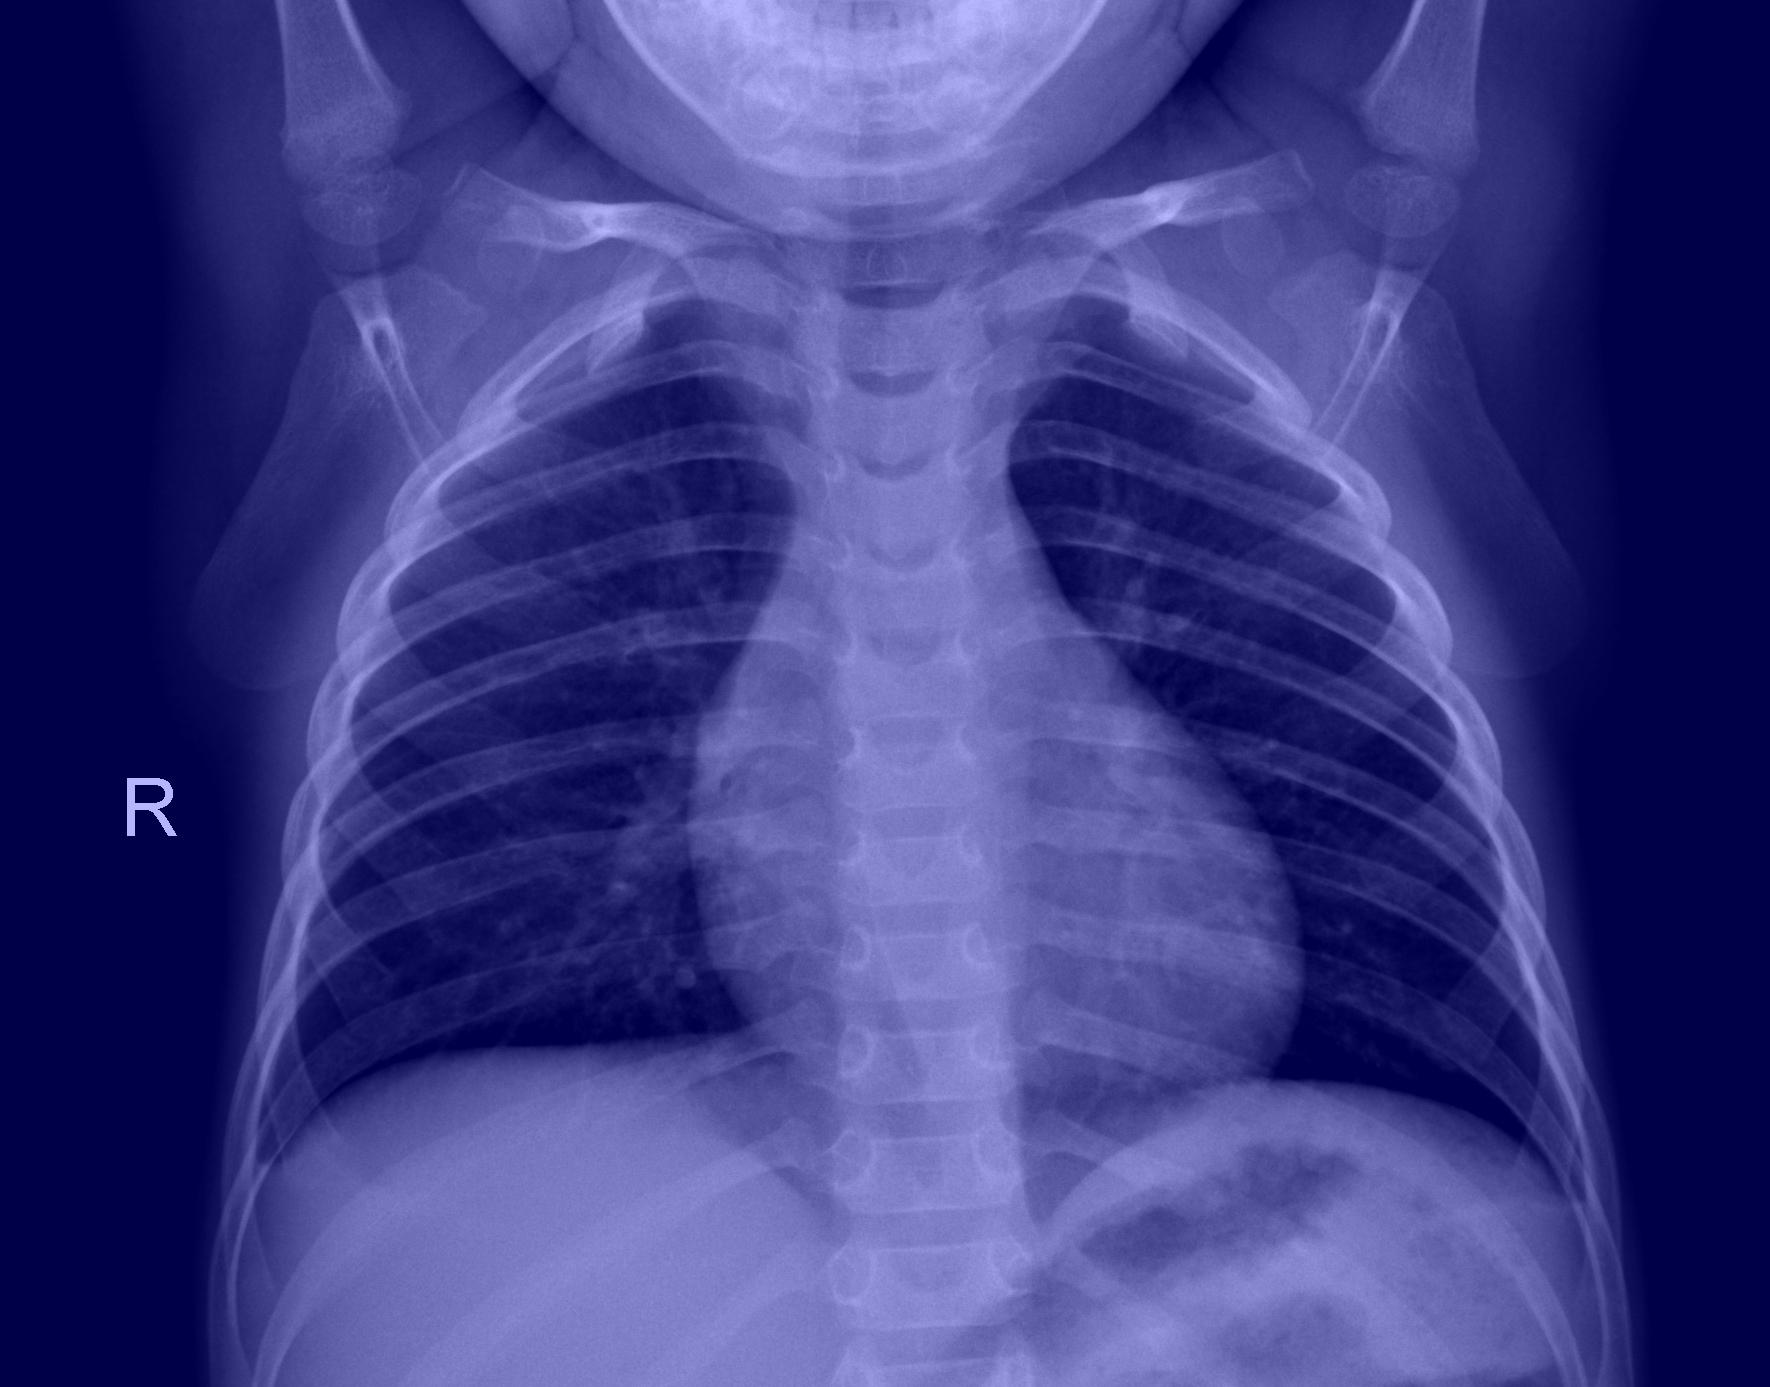

In [14]:
img_path ="../All_data_4_classes/NORMAL/IM-0226-0001.jpeg"
Image_address_name = "../Assets/Grad_cam/Grad_cam_Normal.jpg"
GRAD_CAM_Func(img_path, Image_address_name, last_conv_layer_name="conv2d_10")

## Covid case

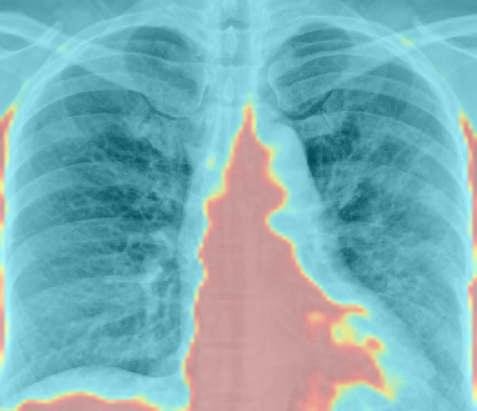

In [15]:
img_path ="../All_data_4_classes/COVID/1-s2.0-S1684118220300608-main.pdf-001.jpg"
Image_address_name = "../Assets/Grad_cam/Grad_cam_Covid.jpg"
GRAD_CAM_Func(img_path, Image_address_name, last_conv_layer_name="conv2d_10")

## Streptococcus

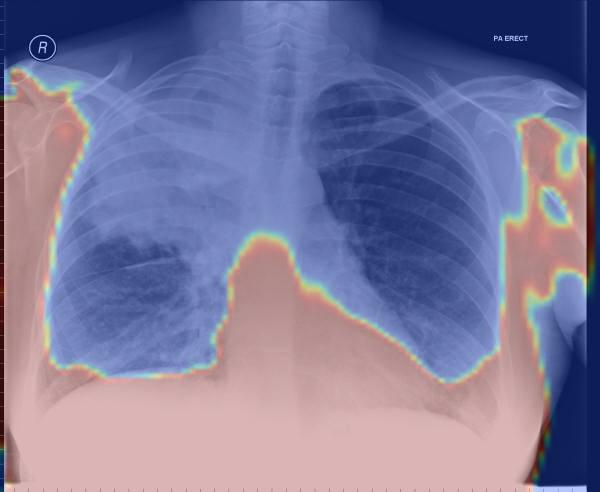

In [16]:
img_path ="../All_data_4_classes/Streptococcus/000004.png"
Image_address_name = "../Assets/Grad_cam/Grad_cam_Streptococcus.jpg"
GRAD_CAM_Func(img_path, Image_address_name, last_conv_layer_name="conv2d_10")

## Pneumocystis

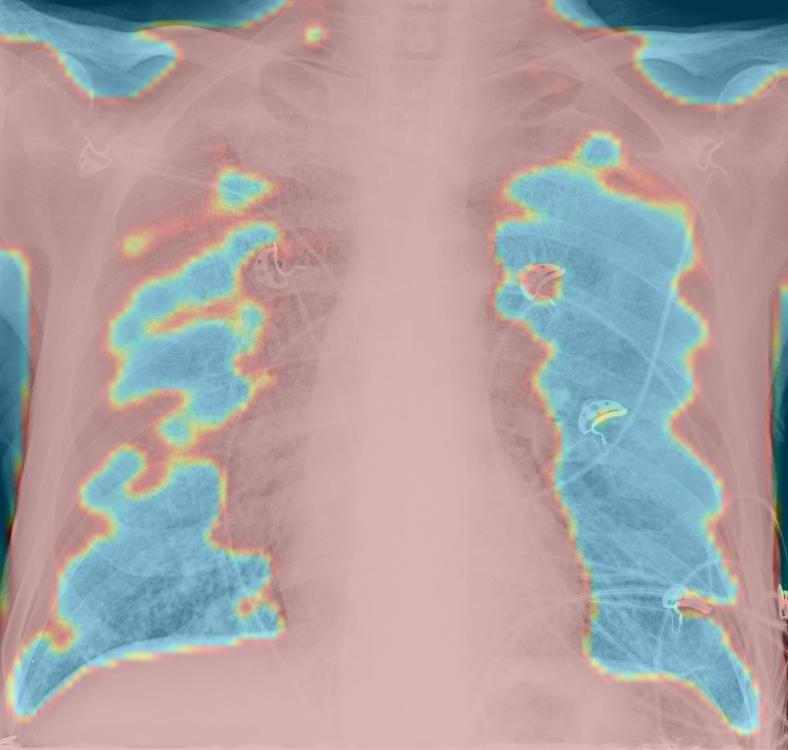

In [17]:
img_path ="../All_data_4_classes/Pneumocystis/pneumocystis-pneumonia-12.png"
Image_address_name = "../Assets/Grad_cam/Grad_cam_Pneumocystis.jpg"
GRAD_CAM_Func(img_path, Image_address_name, last_conv_layer_name="conv2d_10")